In [1]:
!pip install python-louvain

  Running setup.py bdist_wheel for python-louvain ... error
  Complete output from command /home/david/Github/TwitterCovid19-analysis/.venv/bin/python3 -u -c "import setuptools, tokenize;__file__='/tmp/pip-build-atwrb_ly/python-louvain/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" bdist_wheel -d /tmp/tmpk2p7ifu4pip-wheel- --python-tag cp35:
  usage: -c [global_opts] cmd1 [cmd1_opts] [cmd2 [cmd2_opts] ...]
     or: -c --help [cmd1 cmd2 ...]
     or: -c --help-commands
     or: -c cmd --help
  
  error: invalid command 'bdist_wheel'
  
  ----------------------------------------
  Failed building wheel for python-louvain
  Running setup.py clean for python-louvain
Failed to build python-louvain
  Running setup.py install for python-louvain ... done


In [27]:
from heapq import nlargest

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns

from utilities import load_graph_from_files, load_concept_counts
%matplotlib inline

In [28]:
# define your region
REGION = 'netherlands'

In [29]:
# load graph (and nodes, for relabeling)
g, nodes_df = load_graph_from_files(region=REGION)

In [30]:
import community

def get_communities(g):
    """
    Creates communities for a given graph

    :param g: the graph to analyse communities in
    :return: dict of nodes with corresponding community, list of communities with all their nodes
    """

    # create dict of each node (key) with its community (value)
    partitions = community.best_partition(g.to_undirected())

    # dict of communities with empty lists
    communities = {k: [] for k in partitions.values()}

    # fill all nodes to the corresponding community
    for key, value in partitions.items():
        communities[value].append(key)

    # return dict of nodes and dict of communities
    return partitions, communities

In [32]:
# load partitions and communities
partitions, _communities = get_communities(g)

# wrap for nicer usage
communities =  {key: {'nodes' : value} for key, value in _communities.items()}

Amount of communities larger than the mean (6.414244566640482): 126


[(0, 3823.0212690078706)]

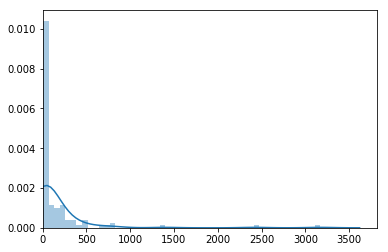

In [33]:
# get sizes for every community
all_lens = [len(c['nodes']) for _, c in communities.items()]

# get communities larger than the mean
lens_larger_than_mean = [x for x in all_lens if x > np.mean(all_lens)]
print('Amount of communities larger than the mean ({}): {}'.format(np.mean(all_lens), len(lens_larger_than_mean)))

# plot distribution
sns.distplot(lens_larger_than_mean).set(xlim=0)

In [34]:
# only includes communities with above average size
top_communities = {}

# for each community
for key, community in communities.items():
    # if its size is above average
    if len(community['nodes']) > np.mean(all_lens):
        top_communities[key] = community

In [35]:
# for each community
for key, community in top_communities.items():
    
    # create copy of graph
    sub_g = nx.Graph(g)
    
    # remove all nodes that do not belong to community
    sub_g.remove_nodes_from([node for node in g.nodes if node not in community['nodes']])
    
    # cache graph
    community['graph'] = sub_g
    
    # order nodes by degree
    degree_nodes = sorted(sub_g.degree, key=lambda x: x[1], reverse=True)
    
    # community named after node with highest degree
    community['name'] = degree_nodes[0][0]

In [ ]:
# for each community
for key, community in top_communities.items():
    # load concepts (with counts) for all corresponding tweets
    community['concepts'] =  load_concept_counts(where="(tweet_body->'user'->>'id_str')::float IN ({})".format(','.join(str(node) for node in community['nodes'])))

In [9]:
# init empty dict of concepts
overall_concept_counts = {}

# run through all communities
for key, community in top_communities.items():
    # increment concept counter if concept found in this community
    for concept in community['concepts']['concept']:
        if concept not in overall_concept_counts:
            overall_concept_counts[concept] = 0
        else:
            overall_concept_counts[concept] = overall_concept_counts[concept] + 1
            

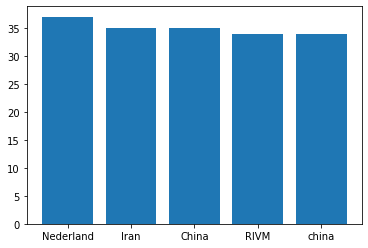

In [12]:
# get the top 5 concepts
top_overall_concept_counts_keys = nlargest(5, overall_concept_counts, key=overall_concept_counts.get)
top_overall_concept_counts = {key : overall_concept_counts[key] for key in top_overall_concept_counts_keys}

# plot them as a bar chart
plt.bar(range(len(top_overall_concept_counts)), list(top_overall_concept_counts.values()), align='center')
plt.xticks(range(len(top_overall_concept_counts)), list(top_overall_concept_counts.keys()))
plt.show()